#Part B - Classify player position 
## Team Members: Navya sri Kalli, Kuldeep Prasad, Hemani Shah, Rohit Raj


### Importing necessary libraries.

In [20]:
#importing necessary files
import pandas as pd
import numpy as np

#importing the libraries for creating a  model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

#for creating graph
import matplotlib.pyplot as plt

In [21]:
def pre_process_dataset(df, train, Scaler):
    
    #Remove the last 31 columns 
    df = df.iloc[: , :-31]

    # Remove the columns suggested in the project description
    df.drop(["sofifa_id", "player_url", "short_name","long_name", "real_face", "potential"],axis=1,inplace=True)

    # Remove the columns that should not make a difference
    df.drop(["dob", "nationality", "club","team_position", "body_type", "loaned_from", "joined", "contract_valid_until"],axis=1,inplace=True)

    # Removing the columns for team_jersey_number and nation_jersey_number. These should not make a difference
    df.drop(["player_tags", "team_jersey_number", "nation_jersey_number"],axis=1,inplace=True)

    # Dropping rows of players which do not have a player_positions
    na = pd.notnull(df["player_positions"])
    df = df[na]

    # Filling the NaN values with 0
    for i in df.columns[14:26]:
        print("filling missing values in :"+i)
        df[i]=df[i].fillna(0)
    print()

    # Using the eval function on the last columns
    for i in df.columns[27:]:
        print("evaluating values in column :"+i)
        df[i]=df[i].apply(lambda x: eval(x) if isinstance(x,str) else x)
    print()

    # Encoding Qualitative Attributes
    df["preferred_foot"] = df["preferred_foot"].map({"Left":0, 'Right':1})
    df["release_clause_eur"].fillna(0.0, inplace=True)
    df["nation_position"]= df["nation_position"].apply(lambda x:0 if x == np.nan else 1)

    # Dividing the player_positions into foward_player, midfielder_player, defender_player and goalkeeper
    forward_player = ["ST", "LW", "RW", "LF", "RF", "RS","LS", "CF"]
    midfielder_player = ["CM","RCM","LCM", "CDM","RDM","LDM", "CAM", "LAM", "RAM", "RM", "LM"]
    defender_player = ["CB", "RCB", "LCB", "LWB", "RWB", "LB", "RB"]

    # Changing the player positions into list of numbers 
    x = df["player_positions"]
    m = []
    for i in x:
      z = i.split(',')
      nz = []
      for j in z:
        j = j.strip()
        if j == "GK":
            n = 0
        elif j in defender_player:
            n = 1
        elif j in midfielder_player:
            n = 2
        elif j in forward_player:
            n = 3
        nz.append(n)
      m.append(nz)
    print(len(m))
    df["player_positions"] = m
    
    # Creating 4 more columns to represent if a player is a forward_player, midfield_player, defender_player and Goalkeeper
    # For Example the column value for FW is 1 if the player is a forward_player and 0 if they are not 
    l = df.shape[0]

    x = df['player_positions']
    GK1=[0]*l
    DF1=[0]*l
    MF1=[0]*l
    FW1=[0]*l
    for i in range(len(x)):
      for j in x[i]:
        if j == 0:
          GK1[i] = 1
        if j == 1:
          DF1[i] = 1
        if j == 2:
          MF1[i] = 1  
        if j == 3:
          FW1[i] = 1

    # Concatinating the dataframe created by joining the 4 columns we created with the actual dataset
    da = {'GK' : GK1 , 'DF': DF1 ,'MF' : MF1 ,'FW' : FW1}
    m = pd.DataFrame(da)
    df = pd.concat([df,m],axis=1)

    # Droping player_positions
    df.drop(["player_positions"], axis=1, inplace=True)

    #Each work rate column has two values for attacking and defending
    # One hot encoding work_rate_att and work_rate_def 
    df["work_rate_att"]=df["work_rate"].apply(lambda x: x.split("/")[0])
    df["work_rate_def"]=df["work_rate"].apply(lambda x: x.split("/")[1])
    df_att=pd.get_dummies(df["work_rate_att"],prefix="work_rate_att",drop_first=False)
    df_def=pd.get_dummies(df["work_rate_def"],prefix="work_rate_def",drop_first=False)
    df=pd.concat([df,df_att,df_def],axis=1)
    df.drop(["work_rate", "work_rate_att", "work_rate_def"],axis=1,inplace=True)

    # Replacing the traits values with the number of traits a player has
    # For Example if a player has two traits it will be replaced by 2
    df["player_traits"].fillna('', inplace=True)
    for i in range(df.shape[0]):
        a=df["player_traits"].iloc[i]
        b=len(a.split(','))
        if a=='':
            b=0
        df["player_traits"].iloc[i]=b

    # Converting all the columns to type integer
    for i in df.columns:
        print('converting '+i)
        df[i] = df[i].apply(pd.to_numeric)

    df.reset_index(drop=True, inplace=True)

    # Removing the columns which are not required to be standandardized
    cols = list(df.columns.values) #Make a list of all of the columns in the df
    cols.pop(cols.index('preferred_foot')) #Remove b from list
    cols.pop(cols.index('overall')) #Remove x from list
    df = df[cols+['preferred_foot','overall']] 
    cols = list(df.columns.values)
    
    # Dividing the columns into columns which need to be scaled and ones that do not
    df_ns = df.iloc[: , 52:].values
    df_s= df.iloc[: , :52].values

    # Transforming the testing data and fit_transforming the training data
    if (train):
        df_s = Scaler.fit_transform(df_s)
    else:
        df_s = Scaler.transform(df_s)

    # Concatinating the dataframe with the scaled dataframe and not scaled dataframe 
    df=pd.concat([pd.DataFrame(df_s), pd.DataFrame(df_ns)],axis=1)
    df.columns = cols

    return df, Scaler

###Creating train and test datasets for each type of player

In [22]:
#Reading the training dataset
df = pd.read_csv("https://raw.githubusercontent.com/rraj29/data/main/players_19.csv")

#Reading the testing dataset
df_test = pd.read_csv("https://raw.githubusercontent.com/rraj29/data/main/players_20.csv")

#Considering only the players from the following clubs (as given in the problem statement)
club_list=["FC Barcelona","FC Bayern München","Real Madrid","Paris Saint-Germain","Juventus","Manchester City","Atlético Madrid","Liverpool","Manchester United"]
df_test=df[df["club"].isin(club_list)]
df_test.reset_index(drop=True, inplace=True)

#Scaling the data
Scaler = StandardScaler()
df, Scaler = pre_process_dataset(df, train=True, Scaler=Scaler)
df_test, Scaler_test = pre_process_dataset(df_test, train=False, Scaler=Scaler)

#Get all the columns except 'FW' as the predictors
X_FW = df.drop(['FW'],axis=1).values
X_test_FW = df_test.drop(['FW'],axis=1).values

#Select 'FW' as the response variable
y_FW = df['FW'].values
y_test_FW = df_test['FW'].values


#Get all the columns except 'DF' as the predictors
X_DF = df.drop(['DF'],axis=1).values
X_test_DF = df_test.drop(['DF'],axis=1).values

#Select 'DF' as the response variable
y_DF = df['DF'].values
y_test_DF = df_test['DF'].values

#Get all the columns except 'MF' as the predictors
X_MF = df.drop(['MF'],axis=1).values
X_test_MF = df_test.drop(['MF'],axis=1).values

#Select 'MF' as the response variable
y_MF = df['MF'].values
y_test_MF = df_test['MF'].values

#Get all the columns except 'GK' as the predictors
X_GK = df.drop(['GK'],axis=1).values
X_test_GK = df_test.drop(['GK'],axis=1).values

#Select 'GK' as the response variable
y_GK = df['GK'].values
y_test_GK = df_test['GK'].values

filling missing values in :pace
filling missing values in :shooting
filling missing values in :passing
filling missing values in :dribbling
filling missing values in :defending
filling missing values in :physic
filling missing values in :gk_diving
filling missing values in :gk_handling
filling missing values in :gk_kicking
filling missing values in :gk_reflexes
filling missing values in :gk_speed
filling missing values in :gk_positioning

evaluating values in column :attacking_crossing
evaluating values in column :attacking_finishing
evaluating values in column :attacking_heading_accuracy
evaluating values in column :attacking_short_passing
evaluating values in column :attacking_volleys
evaluating values in column :skill_dribbling
evaluating values in column :skill_curve
evaluating values in column :skill_fk_accuracy
evaluating values in column :skill_long_passing
evaluating values in column :skill_ball_control
evaluating values in column :movement_acceleration
evaluating values in col

/usr/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


###Creating The Model to predict player positions
We created the model by implementing 4 different logistic regressions. These Logistic Regression models predicted if a player was a Goalkeeper or not, Forward Player or not, Midfield Player or not, Defender Player or not individually.</br>
We then combined the predictions from each of these regressions to get the player positions of each player</br>
Each output had 4 columns now which comprised of zeros and ones.
Now we compared them to the actual player positions.</br>

We got the inspiration for this model when we were trying to fit a neural network to this data. We were getting an accuracy of around 60% only, which we thought was not good enough, we tried tweaking the model, but the accuracy didn't get affected much.</br> We figured out that the major issue was that the model was classifing the player in only one of the four category, when the player had more than one positions. </br>
After many trials with multiouput regressor, neural network, simple logistic regression, we came up with this model.</br>

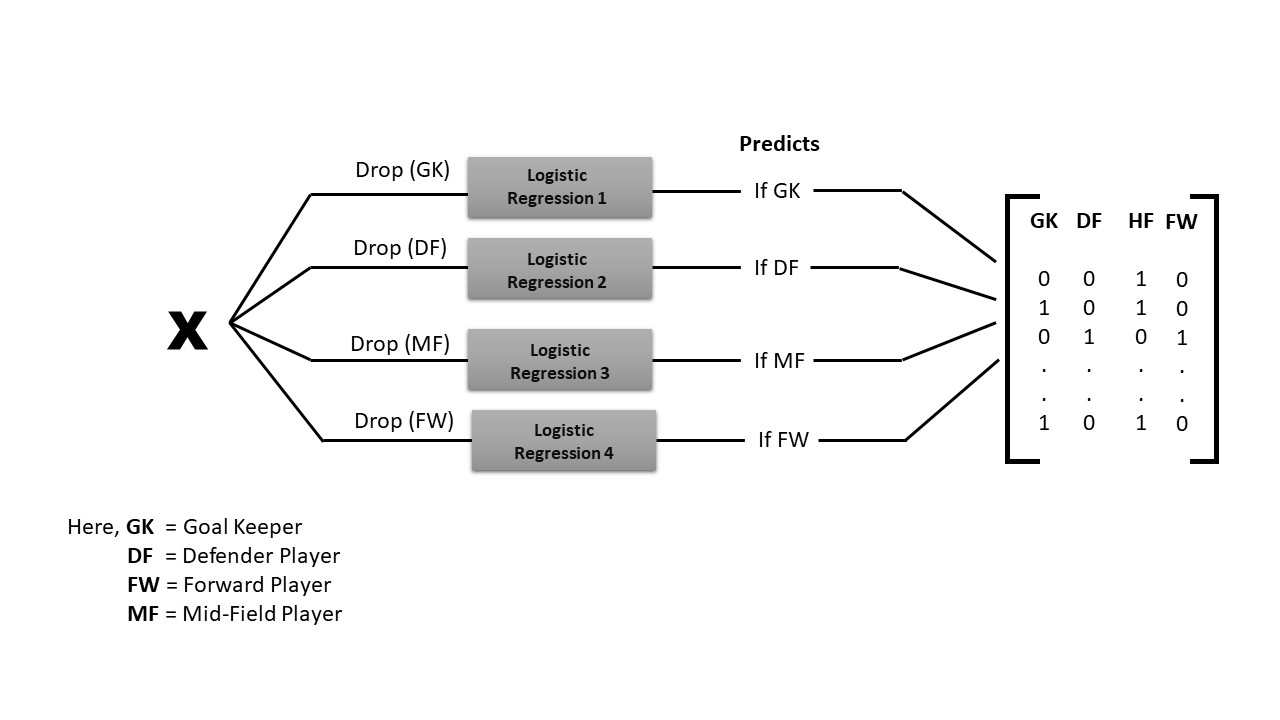

**Creating 4 Logistic Regression models to predict if a player is a:</br>**
Goalkeeper or not,</br>
Forward Player or not</br>
Midfield Player or not</br>
Defender Player or not</br>


In [23]:
# Logitic Regression to clasify the player as Defender or not.
lreg = LogisticRegression(max_iter = 20000,C=100000)
lreg.fit(X_DF,y_DF)
y_train_pred_DF = lreg.predict(X_DF)
y_test_pred_DF = lreg.predict(X_test_DF)

# Finding the test and train accuracy
train_accuracy = accuracy_score(y_DF, y_train_pred_DF)
test_accuracy = accuracy_score(y_test_DF,y_test_pred_DF)
print("The training data accuracy for predicting if the player is a Defender or not is {:.2f}".format(train_accuracy))
print("The testing data accuracy for predicting if the player is a Defender or not is {:.2f}".format(test_accuracy))

The training data accuracy for predicting if the player is a Defender or not is 0.95
The testing data accuracy for predicting if the player is a Defender or not is 0.97


In [24]:
# Logitic Regression to clasify the player as Forward Player or not.
lreg1 = LogisticRegression(max_iter = 20000,C=100000)
lreg1.fit(X_FW,y_FW)
y_train_pred_FW = lreg1.predict(X_FW)
y_test_pred_FW = lreg1.predict(X_test_FW)

# Finding the test and train accuracy
train_accuracy = accuracy_score(y_FW, y_train_pred_FW)
test_accuracy = accuracy_score(y_test_FW,y_test_pred_FW)
print("The training data accuracy for predicting if the player is a Forward Player or not is {:.2f}".format(train_accuracy))
print("The testing data accuracy for predicting if the player is a Forward Player or not is {:.2f}".format(test_accuracy))

The training data accuracy for predicting if the player is a Forward Player or not is 0.93
The testing data accuracy for predicting if the player is a Forward Player or not is 0.93


In [25]:
# Logitic Regression to clasify the player as MidField Player or not.
lreg2 = LogisticRegression(max_iter = 20000,C=100000)
lreg2.fit(X_MF,y_MF)
y_train_pred_MF = lreg2.predict(X_MF)
y_test_pred_MF = lreg2.predict(X_test_MF)

# Finding the test and train accuracy
train_accuracy = accuracy_score(y_MF, y_train_pred_MF)
test_accuracy = accuracy_score(y_test_MF,y_test_pred_MF)
print("The training data accuracy for predicting if the player is a MidField Player or not is {:.2f}".format(train_accuracy))
print("The testing data accuracy for predicting if the player is a MidField Player or not is {:.2f}".format(test_accuracy))

The training data accuracy for predicting if the player is a MidField Player or not is 0.87
The testing data accuracy for predicting if the player is a MidField Player or not is 0.89


In [26]:
# Logitic Regression to clasify the player as GoalKeeper or not.
lreg3 = LogisticRegression(max_iter = 20000,C=100000)
lreg3.fit(X_GK,y_GK)
y_train_pred_GK = lreg3.predict(X_GK)
y_test_pred_GK = lreg3.predict(X_test_GK)

# Finding the test and train accuracy
train_accuracy = accuracy_score(y_GK, y_train_pred_GK)
test_accuracy = accuracy_score(y_test_GK,y_test_pred_GK)
print("The training data accuracy for predicting if the player is a GoalKeeper or not is {:.2f}".format(train_accuracy))
print("The testing data accuracy for predicting if the player is a GoalKeeper or not is {:.2f}".format(test_accuracy))

The training data accuracy for predicting if the player is a GoalKeeper or not is 1.00
The testing data accuracy for predicting if the player is a GoalKeeper or not is 1.00


###Creating y_train_pred, y_test_pred,y_train and y_test

In [27]:
# Creating y_train_pred and y_test_pred
y_train_pred = np.column_stack([y_train_pred_GK,y_train_pred_DF,y_train_pred_MF,y_train_pred_FW])
y_test_pred = np.column_stack([y_test_pred_GK,y_test_pred_DF,y_test_pred_MF,y_test_pred_FW])

# Creating y_train and y_test
y_train = np.column_stack([y_GK,y_DF,y_MF,y_FW])
y_test = np.column_stack([y_test_GK,y_test_DF,y_test_MF,y_test_FW])

###Calculating the Accuracy of the Model. We have created 2 accuracies:</br>
1.Absolute Accuracy: When our prediction **exactly** matches the actual player_positions</br>
2.Relative Accuracy: When our prediction matches atleast one of the player_positions of that player  


In [28]:
# Finding the total length y_train and y_test
total_train = y_train.shape[0]
total_test = y_test.shape[0]

In [29]:
# Finding the difference between true y values and the predicted y values
# If the dif_train or test has a [0,0,0,0] value it means we have predicted all the values correctly
# We use the abs function to make sure that all the values is positive so that there no rows like [0 -1 0 1]
# These types of rows will give us the wrong accuracy when we add them together in the next steps it will give us a zero value 
# Thus causing us to predict a False Positive
dif_train = np.abs(y_train_pred-y_train)
dif_test = np.abs(y_test_pred-y_test)

In [30]:
print(dif_train)

[[0 0 0 0]
 [0 0 0 0]
 [0 0 1 0]
 ...
 [0 0 0 0]
 [0 0 0 1]
 [0 0 0 0]]


In [31]:
# Adding all the values in a particular row
# We will get an array of zeros or positive values
# The zeros are the exactly correct predictions while the positive values are the wrong predictions 
sum_train = np.sum(dif_train, axis = 1)
sum_test = np.sum(dif_test, axis=1)

In [32]:
# Finding the values which are more than zero
# If the value is more than zero then atleast one element is different
# So our prediction is wrong

# Counting the number of wrong predictions
wrong_train = np.sum(sum_train > 0, axis=0)
wrong_test = np.sum(sum_test > 0, axis=0)

In [33]:
# We defined the accuracy as the ratio of number of correct predictions to the number of total predictions 
acc_train = 1-wrong_train/total_train
acc_test = 1-wrong_test/total_test
print("The Absolute Training Accuracy is {:.2f}".format(acc_train))
print("The Absolute Testing Accuracy is {:.2f}".format(acc_test))

The Absolute Training Accuracy is 0.77
The Absolute Testing Accuracy is 0.80


In [34]:
# Defining a function for a new matrix which caluculates the accuracy in a realtive fashion.
# For Example,if y_train = [0,0,1,1] and y_train_pred = [0,0,1,0] it will still count it as a correct prediction unlike the previous metric
def acc(c,d):
  rows = c.shape[0]
  columns = c.shape[1]
  counts = 0
  keep = []
  for i in range(rows):
    cnt = 0
    for j in range(columns):
      if c[i][j] == 1 and  d[i][j] ==1:
        cnt+=1
      else:
        continue
    if cnt>=1:
      counts +=1
      keep.append(1)
  accuracy= counts/rows
  return accuracy

In [35]:
# Printing the relative metric
print("The Relative Metric for the Training Data is {:.2f}".format(acc(y_train,y_train_pred)))
print("The Relative Metric for the Testing Data is {:.2f}".format(acc(y_test,y_test_pred)))

The Relative Metric for the Training Data is 0.99
The Relative Metric for the Testing Data is 1.00


**Since we have a relatively small testing dataset, The relative accuracy is very high compared to the absolute accuracy**

##Graphically representing predicted player_position for the players in Test Set

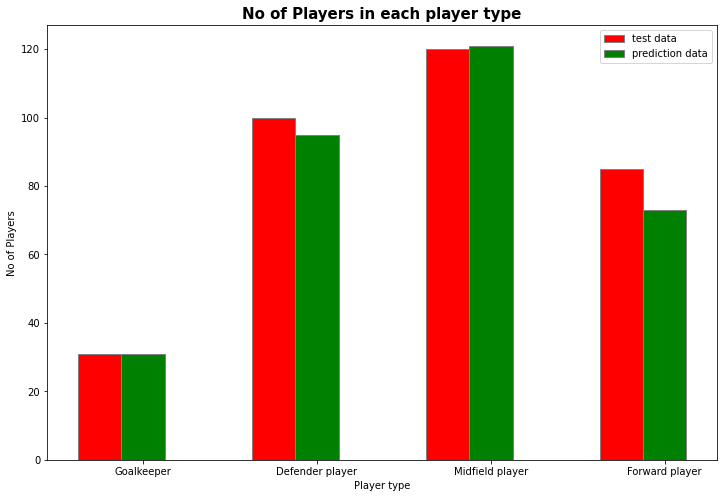

In [36]:
#Graphically representing predicted player_position for the players in Test Set
test = np.sum(y_test, axis=0)
test_pred = np.sum(y_test_pred, axis=0)

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(test))
br2 = [x + barWidth for x in br1]

plt.bar(br1, test, color ='r', width = barWidth,
        edgecolor ='grey', label ='test data')
plt.bar(br2, test_pred, color ='g', width = barWidth,
        edgecolor ='grey', label ='prediction data')

plt.xlabel('Player type')
plt.ylabel('No of Players')
plt.xticks([r + barWidth for r in range(len(test))],
           ['Goalkeeper','Defender player','Midfield player','Forward player'])
plt.title('No of Players in each player type', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

##Can a professional defender become a forward?

In [37]:
# Creating a function to see if a player is a defender in one year and becomes a forward player in the following years
# We have checked this for the team position of the player
# We have assumed that a player can only be called a professional defender if his team position is a defender position
def defendertoforward(filename1,filename2):
  df1 = pd.read_csv(filename1)
  df2 = pd.read_csv(filename2)

  df1 = df1[["short_name","sofifa_id","team_position"]]
  df2 = df2[["short_name","sofifa_id","team_position"]]

  forward_player = ["ST", "LW", "RW", "LF", "RF", "RS","LS", "CF"]
  defender_player = ["CB", "RCB", "LCB", "LWB", "RWB", "LB", "RB"]

  s = []
  for i in range(len(df1["team_position"])):
    if df1["team_position"][i] in (defender_player):
      s.append(df1["sofifa_id"][i])
  
  x = []
  for i in range(len(df2["team_position"])):
    if (df2["sofifa_id"][i] in s) and (df2["team_position"][i] in (forward_player)):
      x.append(df2["short_name"][i])
  
  return x


In [38]:
# Creating an empty list to store the names of the players who were defenders and became forward players
x = []

# Creating a list of filenames 
filenames = ["https://raw.githubusercontent.com/rraj29/data/main/players_15.csv", "https://raw.githubusercontent.com/rraj29/data/main/players_16.csv", "https://raw.githubusercontent.com/rraj29/data/main/players_17.csv", "https://raw.githubusercontent.com/rraj29/data/main/players_18.csv", "https://raw.githubusercontent.com/rraj29/data/main/players_19.csv", "https://raw.githubusercontent.com/rraj29/data/main/players_20.csv"]

# Calling the function defendertoforward() in such a way that filename2 always has the data of players in a year that is after the year of filename1 
for i in range(len(filenames)):
  for j in range(i+1,len(filenames)):
    x = x + defendertoforward(filenames[i],filenames[j])

#printing unique names of players who were defenders and became forward players
print("The players who were defenders and became forward players are:")
for i in set(x):
  print("    {}".format(i))

The players who were defenders and became forward players are:
    T. Kalachev
    A. Silva
    C. Goodwin
    J. Beausejour
    R. Sessegnon
    C. Winchester
    L. Akins
    J. Parr
    Hildeberto Pereira
    J. Lukaku
    B. Véjar
    M. Vilhjálmsson
    A. Reach
    F. Acheampong
    E. Tønne
    M. Diouf
    F. Brown Forbes
    A. Frączczak


**Yes, a defender can become a forward player. Although, the probability is very low. As we can see in the cell above only 18 Defenders have been able to become Forwards in the time period: 2015 to 2020**